In [38]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap


In [39]:
csv_files = ['ap_2010.csv','class_size.csv','demographics.csv', 'graduation.csv', 'hs_directory.csv', 'sat_results.csv']
text_files = ['survey_all.txt', 'survey_d75.txt']

##### creating a dictionary of all the datasets

In [40]:
data = {}
for file in csv_files:
    file_name = file.split('.')
    data[file_name[0]]= pd.read_csv(file)

##### correcting "survey" data set and add it to the dictionary

In [41]:
#read the file with its encoding
survey_all = pd.read_csv(text_files[0], sep = '\t', encoding = 'cp1252')
survey_d75 = pd.read_csv(text_files[1], sep = '\t', encoding = 'cp1252')

#merging two data set to one
survey = pd.concat([survey_all, survey_d75], axis = 0)

#add survey to the data dictionary by choosing the custom and useful columns
survey['DBN'] = survey['dbn']
custom_columns = ["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]
survey = survey[custom_columns].copy()
data['survey'] = survey

##### correcting "class_size" data set by adding DBN column

In [42]:
#function to add a zero to left side of the numbers in CSD column
def correct_CSD(column):
    CSD = str(column).zfill(2) 
    column = CSD
    return column
data['class_size']['CSD'] = data['class_size']['CSD'].apply(correct_CSD)

#create DBN column
data['class_size']['DBN'] = data['class_size']['CSD'] + data['class_size']['SCHOOL CODE']

#move DBN column to the front
cols = list(data['class_size'])
cols.insert(0, cols.pop(cols.index('DBN')))
data['class_size'] = data['class_size'].loc[:, cols]

##### correcting "hs_directory" data set

In [43]:
data['hs_directory'].rename(columns = {'dbn':'DBN'}, inplace = True)

##### correcting "ap_2010" data types to float

In [44]:
for column in data['ap_2010'].columns[2:]:
    data['ap_2010'][column] = pd.to_numeric(data['ap_2010'][column], errors = 'coerce')

##### extracting and adding latitude and longitude columns to "hs_directory" for further use

In [45]:
#function to extract the latitude and longitude from column "Location 1"
def add_coordinates (column):
    if column == "NaN":
        return None
    else:
        location = re.findall('\(.+\)',column)
        location = location[0].split(',')
        latitude = float(location[0][1:])
        longitude = float(location[1][:-1])
        coordinates = [latitude, longitude]
        return coordinates

#apply the function and assign the results to coordinates and create two list from it to add to the main dataframe    
coordinates = data['hs_directory']['Location 1'].apply(add_coordinates)
latitude = []
longitude = []
for cor in coordinates:
    latitude.append(cor[0])
    longitude.append(cor[1])

#add the new columns to DataFrame
data['hs_directory']['latitude'] = latitude
data['hs_directory']['longitude'] = longitude

##### condensing the 'class_size' by deleting the rows that are not useful i.e. not for high school students or 

In [46]:
#finding all the possible values for 'GRADE' column
data['class_size']['GRADE '].unique()
#we just want the '09-12' for high school students, so delete the other rows if the GRADE is not '09-12'
data['class_size'] = data['class_size'][data['class_size']['GRADE '] == '09-12']

#finding the possible values for Program type and their number of repetition
data['class_size']['PROGRAM TYPE'].unique()
        
#GEN ED is the most popular TYPE so delete the rest
data['class_size'] = data['class_size'][data['class_size']['PROGRAM TYPE'] == 'GEN ED']

#grouping and aggregating based on the DBN and average of other columns
data['class_size'] =  data['class_size'].groupby('DBN', as_index = False).mean()

##### condensing the 'demographics' by deleting the rows other than the schoolyear of 20112012 which is the same as the sat results year

In [47]:
data['demographics'] = data['demographics'][data['demographics']['schoolyear'] == 20112012]

##### condensing the 'graduation' by keeping only Total Cohort and  2006 

In [48]:
data['graduation'] = data['graduation'][data['graduation']['Demographic']== 'Total Cohort'];
data['graduation'] = data['graduation'][data['graduation']['Cohort']== '2006'];

##### condensing the 'ap_2010' by deleting one row that was excess 

In [49]:
#find the DBN that is repeated more than one row
for (index, value) in (data['ap_2010']['DBN'].value_counts()).iteritems():
    if value >1:
        print(index, value)
        
#check those rows        
data['ap_2010'][data['ap_2010']['DBN'] == '04M610']

#delete the row that was extra by knowing its index
data['ap_2010'] = data['ap_2010'].drop(52)

04M610 2


##### summing up all the SAT sections to "sat_score"

In [50]:
data['sat_results']['SAT Critical Reading Avg. Score'] = pd.to_numeric(data['sat_results']['SAT Critical Reading Avg. Score'],errors = 'coerce')
data['sat_results']['SAT Math Avg. Score'] = pd.to_numeric(data['sat_results']['SAT Math Avg. Score'],errors = 'coerce')
data['sat_results']['SAT Writing Avg. Score'] = pd.to_numeric(data['sat_results']['SAT Writing Avg. Score'],errors = 'coerce')
data['sat_results']['sat_score'] = data['sat_results']['SAT Critical Reading Avg. Score'] \
                                 + data['sat_results']['SAT Math Avg. Score'] \
                                 + data['sat_results']['SAT Writing Avg. Score']

##### merging all the dataframes

In [51]:
combined = data['sat_results']
combined = combined.merge(data['ap_2010'], how = 'left', on = 'DBN')
combined = combined.merge(data['graduation'], how = 'left', on = 'DBN')
combined = combined.merge(data['class_size'], how = 'inner', on = 'DBN')
combined = combined.merge(data['demographics'], how = 'inner', on = 'DBN')
combined = combined.merge(data['survey'], how = 'inner', on = 'DBN')
combined = combined.merge(data['hs_directory'], how = 'inner', on = 'DBN')

##### filling the NaN values, and droping two repeated columns

In [52]:
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)
combined.drop('SchoolName', axis = 1, inplace = True)
combined.drop('School Name', axis = 1, inplace = True)

##### add school_dist column for further analysis

In [53]:
combined['school_dist'] = combined['DBN'].apply(lambda x : x[0:2] )

***

## Finding Correlations

In [186]:
#all the correlations
correlations = combined.corr()
#finding the correlations with the sat_score
correlations['sat_score'][28:]

white_num            0.450429
white_per            0.621986
male_num             0.327431
male_per            -0.108343
female_num           0.388672
female_per           0.108389
rr_s                 0.231890
rr_t                -0.024694
rr_p                 0.046779
N_s                  0.424319
N_t                  0.292384
N_p                  0.421948
saf_p_11             0.121469
com_p_11            -0.116765
eng_p_11             0.019273
aca_p_11             0.033644
saf_t_11             0.312497
com_t_11             0.080251
eng_t_11             0.034650
aca_t_11             0.130313
saf_s_11             0.336485
com_s_11             0.186068
eng_s_11             0.212497
aca_s_11             0.338242
saf_tot_11           0.317442
com_tot_11           0.074869
eng_tot_11           0.098118
aca_tot_11           0.189005
grade_span_min      -0.017890
grade_span_max            NaN
expgrade_span_min         NaN
expgrade_span_max         NaN
postcode            -0.062054
total_stud

##### checking relation between the sat_score and total_engagment

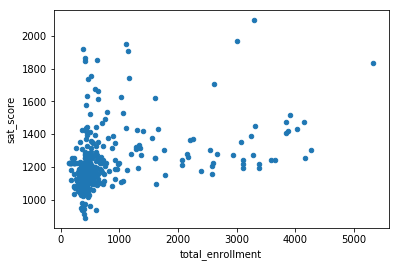

In [55]:
ax = combined.plot(x = 'total_enrollment', y = 'sat_score', kind = 'scatter')
plt.show()

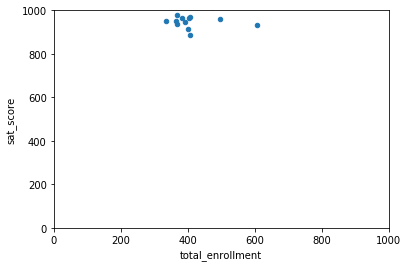

In [56]:
#if I look at the cluster in the left bottom corner :
ax = combined.plot(x = 'total_enrollment', y = 'sat_score', kind = 'scatter')
ax.set_xlim(0,1000)
ax.set_ylim(0,1000)
plt.show()

In [57]:
#find those schools that are in this area in the bottom left corner
low_enrollement = combined[combined['sat_score']<1000]
low_enrollement = low_enrollement[low_enrollement['total_enrollment']<1000]
low_enrollement['SCHOOL NAME']

90                  INTERNATIONAL COMMUNITY HIGH SCHOOL
124                 ACADEMY FOR LANGUAGE AND TECHNOLOGY
125                     BRONX INTERNATIONAL HIGH SCHOOL
138               KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
140               INTERNATIONAL SCHOOL FOR LIBERAL ARTS
175    PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
178                       HIGH SCHOOL OF WORLD CULTURES
187                  BROOKLYN INTERNATIONAL HIGH SCHOOL
224       INTERNATIONAL HIGH SCHOOL AT PROSPECT HEIGHTS
236                          IT TAKES A VILLAGE ACADEMY
252                           MULTICULTURAL HIGH SCHOOL
285              PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

### Conclusion : 
- the high Pierson's r is probably because of this small region, which after checking the name of the schools, turns out to be international schools and this means that the students in these classes are mostly learning English 
- this means that I should check the correlation between the sat_score and 'ell_percent'

In [58]:
combined.columns

Index(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'AP Test Takers ',
       'Total Exams Taken', 'Number of Exams with scores 3 4 or 5',
       ...
       'Location 1', 'Community Board', 'Council District', 'Census Tract',
       'BIN', 'BBL', 'NTA', 'latitude', 'longitude', 'school_dist'],
      dtype='object', length=162)

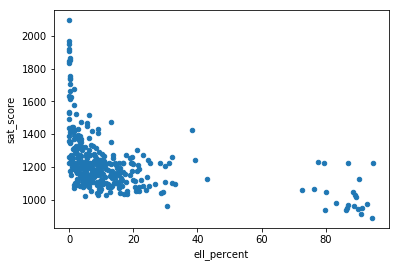

In [59]:
ax = combined.plot(x = 'ell_percent', y = 'sat_score', kind = 'scatter')
plt.show()

#### the cluster in the right bottom is representing the same schools that I found up in the previous section to be mostly international schools
#### the correlation for the english language learners is better than the total_enrollment

/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


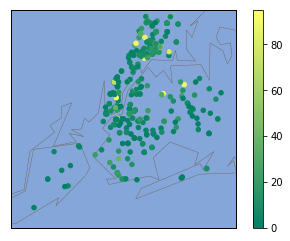

In [61]:
#plotting the language learner percentage for each school on map with colormap
latitude = combined['latitude'].tolist()
longitude = combined['longitude'].tolist()
m = Basemap(projection = 'merc', llcrnrlat= 40.49,urcrnrlat= 40.9, llcrnrlon= -74.25,urcrnrlon =  -73.69, resolution='i')
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F4f', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
#x, y = m(longitude, latitude)
m.scatter(longitude , latitude , s = 20, zorder=2, latlon= True , c = combined['ell_percent'] , cmap = 'summer')
plt.colorbar()
plt.show();


### school density is highest in Manhattan (the top of the map), and lower in Brooklyn, the Bronx, Queens, and Staten Island.

#### the school density is high for some regions, so it is better to plot it for each district

In [65]:
#plotting the percent of english learners for each district
districts =  combined.groupby('school_dist', as_index = False).mean()
districts.head(10)

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,NUMBER OF STUDENTS / SEATS FILLED,...,priority08,priority09,priority10,Community Board,Council District,Census Tract,BIN,BBL,latitude,longitude
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,115.244241,...,0.0,0.0,0.0,3.000000,1.500000,1106.833333,1.004144e+06,1.003302e+09,40.719022,-73.982377
1,02,426.608658,444.176397,424.814746,1295.599800,128.908454,201.516827,157.495833,158.713390,149.818949,...,0.0,0.0,0.0,4.203762,2.964120,1132.687384,1.104040e+06,1.070612e+09,40.739699,-73.991386
2,03,428.508982,437.977794,426.879491,1293.366267,156.183494,244.522436,193.087500,183.496764,156.005994,...,0.0,0.0,0.0,7.500000,6.500000,166.666667,1.034931e+06,1.012833e+09,40.781574,-73.977370
3,04,397.166667,411.333333,398.666667,1207.166667,129.014423,181.685897,150.633333,123.666667,143.040289,...,0.0,0.0,0.0,11.000000,8.000000,3047.833333,1.056517e+06,1.016738e+09,40.793572,-73.942534
4,05,427.147990,438.225406,419.645423,1285.018820,85.722527,115.725275,142.464286,143.805825,120.623901,...,0.0,0.0,0.0,9.428571,8.142857,9372.571429,1.063080e+06,1.019721e+09,40.817077,-73.949251
5,06,382.003593,400.557784,382.051796,1164.613174,108.711538,159.715385,105.425000,181.028155,139.041709,...,0.0,0.0,0.0,11.178056,10.827778,2766.699444,1.226465e+06,1.171199e+09,40.848970,-73.932502
6,07,376.461538,380.461538,371.923077,1128.846154,73.703402,112.476331,105.276923,105.640030,97.597416,...,0.0,0.0,0.0,1.692308,12.846154,58.538462,2.032562e+06,2.024050e+09,40.816815,-73.919971
7,08,386.191617,395.521230,377.868536,1159.581383,118.379371,168.020979,144.731818,215.632833,129.765099,...,0.0,0.0,0.0,7.272727,16.727273,67.909091,2.037043e+06,2.036723e+09,40.823803,-73.866087
8,09,373.751796,383.578892,374.625898,1131.956587,71.411538,104.265385,98.470000,113.398058,100.118588,...,0.0,0.0,0.0,3.550000,15.750000,5243.750000,2.022457e+06,2.027913e+09,40.836349,-73.906240
9,10,403.363636,418.000000,400.863636,1222.227273,132.231206,226.914336,191.618182,161.318182,168.876526,...,0.0,0.0,0.0,7.000000,12.227273,1686.045455,1.856268e+06,1.850558e+09,40.870345,-73.898360


/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


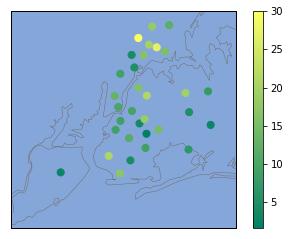

In [112]:
latitude = districts['latitude'].tolist()
longitude = districts['longitude'].tolist()
m = Basemap(projection = 'merc', llcrnrlat= 40.49,urcrnrlat= 40.9, llcrnrlon= -74.25,urcrnrlon =  -73.69, resolution='h')
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F4f', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.scatter(longitude , latitude , s = 50, zorder=2, latlon= True , c = districts['ell_percent'] , cmap = 'summer')
plt.colorbar()
plt.show();



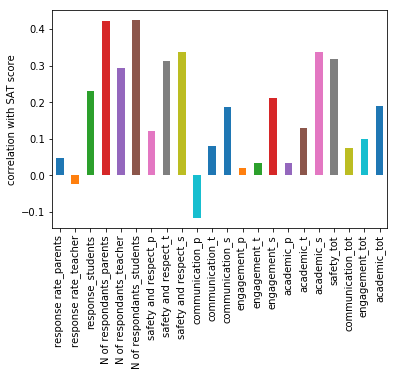

In [146]:
#pplotting the bar plot of the survey results correlations with sat_score
survey_corr = ['rr_p','rr_t','rr_s','N_p','N_t','N_s',\
               'saf_p_11','saf_t_11','saf_s_11',\
               'com_p_11','com_t_11','com_s_11',\
               'eng_p_11','eng_t_11','eng_s_11',\
               'aca_p_11','aca_t_11','aca_s_11',\
               'saf_tot_11','com_tot_11','eng_tot_11','aca_tot_11']
survey_corr_label = ['response rate_parents','response rate_teacher','response_students','N of respondants_parents','N of respondants_teacher','N of respondants_students',\
               'safety and respect_p','safety and respect_t','safety and respect_s',\
               'communication_p','communication_t','communication_s',\
               'engagement_p','engagement_t','engagement_s',\
               'academic_p','academic_t','academic_s',\
               'safety_tot','communication_tot','engagement_tot','academic_tot']
ax = correlations['sat_score'].loc[survey_corr].plot.bar( )
ax.set_xticklabels(survey_corr_label, rotation = 90)
ax.set_ylabel('correlation with SAT score')
plt.show()

### Conclusions:
- It is interesting that the responses from students in all topics have a higher correlation with SAT  score. And the worse correlation is with the parent's responses! 
- This seems to show that the students's responses are more reasonable and they can predict the situation in their school better
- In case of the total score of each item, it seems that safety has the highest correlation with SAT score and after that from high to low, academic situation, engagement, and commncations are in correlation with SAT score
- the number of the respondants for all categories of parents, teachers, students seems to have a high correlation with SAT score. This can emphasize on the correlation of the total enrollment with SAT score
- response rate of the studens has high correlation, and this can show that the students who cared about completing the surve also care more about their academic success

Text(0,0.5,'SAT score')

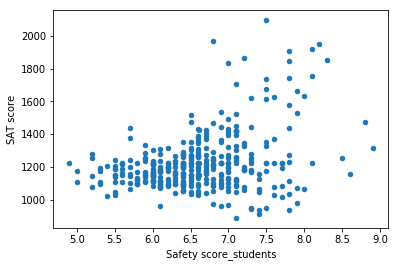

In [109]:
ax = combined.plot.scatter('saf_s_11','sat_score' )
ax.set_xlabel('Safety score_students')
ax.set_ylabel('SAT score')

## Conclusion
- this shows that increasing the safety can affect the SAT score, but its influence is not that strong.
- that is true that by increasing the safety score over 6.5, the SAT scores have improved significantly for a few scholls, but it doesn't mean that the highest SAT score is for schools with highest safety score

/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


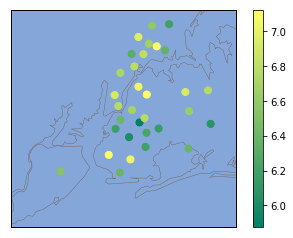

In [142]:
latitude = districts['latitude'].tolist()
longitude = districts['longitude'].tolist()
m = Basemap(projection = 'merc', llcrnrlat= 40.49,urcrnrlat= 40.9, llcrnrlon= -74.25,urcrnrlon =  -73.69, resolution='h')
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F4f', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.scatter(longitude , latitude , s = 50, zorder=2, latlon= True , c = districts['saf_s_11'] , cmap = 'summer');
plt.colorbar();
plt.show();

### Conclusion:
- Brooklyn seems to be safer than Manhattan, Queens, and Bronx

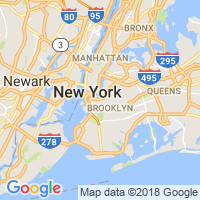

In [141]:
#the map of the area of investigation has been plotted as a reference
from PIL import Image
import requests
from io import BytesIO
url = "http://maps.googleapis.com/maps/api/staticmap?center=40.695,-73.97&size=200x200&zoom=9&sensor=false"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img

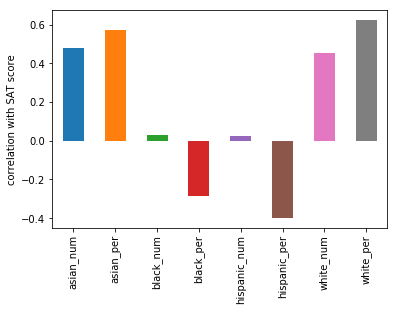

In [147]:
#plotting the bar plot of the races correlations with sat_score
race_corr = ['asian_num','asian_per','black_num','black_per','hispanic_num','hispanic_per','white_num','white_per'] 
ax = correlations['sat_score'].loc[race_corr].plot.bar( )
ax.set_ylabel('correlation with SAT score')
plt.show()

### Conclusion:
- there is a strong negative correlation between the SAT score and the percentage of Black or Hispanic students, 
- there is a strong positive correlation between the SAT score and the percentage of the white or asian students

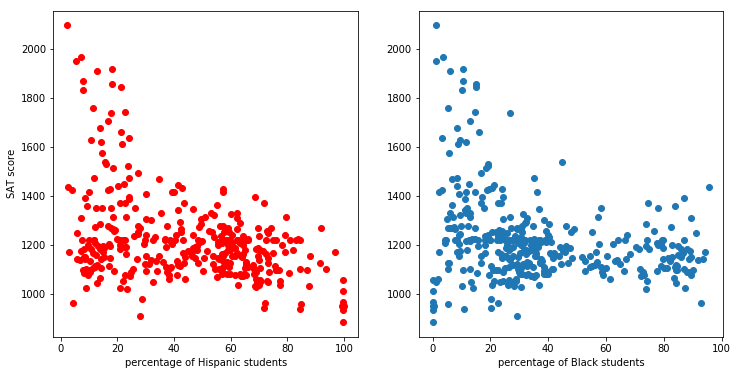

In [179]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,6))
color_map = plt.cm.tab10
ax1.scatter(combined['hispanic_per'],combined['sat_score'], c = 'red');
ax1.set_xlabel('percentage of Hispanic students')
ax1.set_ylabel('SAT score')
ax2.scatter(combined['black_per'],combined['sat_score']);
ax2.set_xlabel('percentage of Black students');


### Conclusion:
- there is a strong negative correlation between both black and hispanic races with SAT score, although it is even stronger visually with hispanic students

In [181]:
combined['school_name'][combined['hispanic_per']>=95]

44                         Manhattan Bridges High School
81      Washington Heights Expeditionary Learning School
88     Gregorio Luperon High School for Science and M...
124                  Academy for Language and Technology
140                International School for Liberal Arts
175     Pan American International High School at Monroe
252                            Multicultural High School
285               Pan American International High School
Name: school_name, dtype: object

### Conclusion:
- by investigating through the schools that have more than 95% Hispanic students, it is understood that these schools are mostly for new immigrants and the students are mostly focused on learning English

In [185]:
combined['school_name'][combined['hispanic_per']<= 10][combined['sat_score']>=1800]

37                                Stuyvesant High School
150                         Bronx High School of Science
186                       Brooklyn Technical High School
326    Queens High School for the Sciences at York Co...
355                  Staten Island Technical High School
Name: school_name, dtype: object

### Conclusion:
- the schools in NY with less than 10% Hispanic students and more than 1800 SAT score, are one of the none specialized high schools in NYC!!

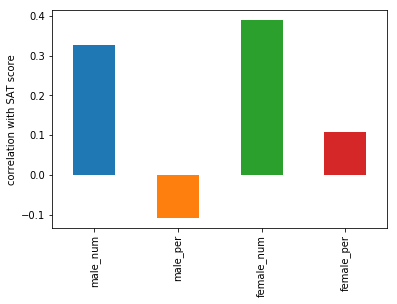

In [187]:
#plotting the bar plot of the genders correlations with sat_score
gender_corr = ['male_num','male_per','female_num','female_per'] 
ax = correlations['sat_score'].loc[gender_corr].plot.bar( )
ax.set_ylabel('correlation with SAT score')
plt.show()


### conclusion:
- there is a stronger correlation between the number of female students and SAT score rather than the number of the male students
- there is a negative correlation between the male percentage and SAT score, which will be further investigated in the next section
- the correlation between the female percentage and SAT score is positive, yet not that strong.

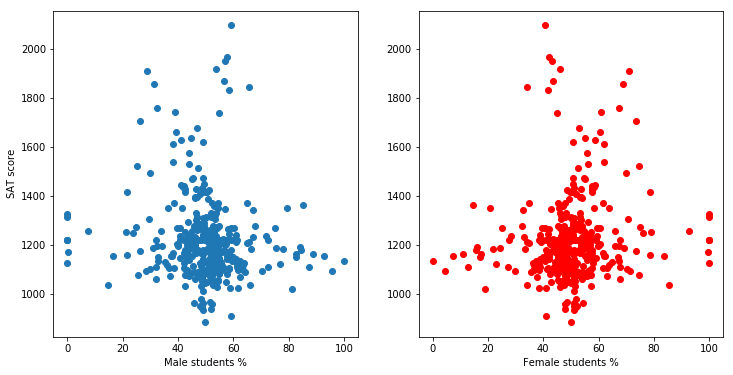

In [190]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,6))
color_map = plt.cm.tab10
ax1.scatter(combined['male_per'],combined['sat_score']);
ax1.set_xlabel('Male students %')
ax1.set_ylabel('SAT score')
ax2.scatter(combined['female_per'],combined['sat_score'], c = 'red');
ax2.set_xlabel('Female students %');

### Conclusion:
- the correlations do not seem to be strong for the genders and SAT scores. there is a cluster for higher SAT scores which may has caused the correlation.

Pearson's r for AP test takers and SAT score is 0.0562813142823


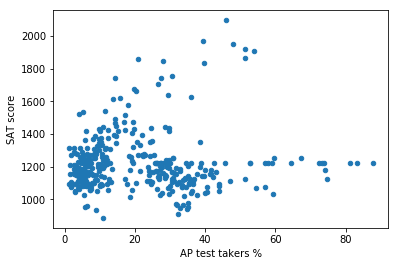

In [203]:
combined['ap_per'] = (combined['AP Test Takers ']/combined['total_enrollment'])*100
print("Pearson's r for AP test takers and SAT score is " + str(combined.corr()['sat_score'].loc['ap_per']))
ax = combined.plot.scatter('ap_per','sat_score' );
ax.set_xlabel('AP test takers %')
ax.set_ylabel('SAT score');

### Conclusion:
- there is a correlation between the % of AP test takers and the SAT score, however, there are still a lot of schools whose students have taken the AP test, but its average SAT score is not high